In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import json

%matplotlib inline  

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

# Define p-value to use for significance
p_value = 0.001

# List files, cell line, condition to be queried for significant features
file_list = [("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_guide_normalized_merged_feature_select_median_ALLWELLS_cp.csv.gz",'HeLa_CP', False)]


In [4]:
#### Load barcodes used in experiment
saber_library = pd.read_csv("SABER_Library_ngt_Included_Oligo_Sequences_Assiged.csv")
guide_list = list(saber_library['sgRNA'])
len(guide_list)

2400

In [20]:
# Extract expression data from the Broad Institute Dependency Map
CCLE_expression = pd.read_csv('CCLE_expression_hela.csv')
CCLE_expression = CCLE_expression.rename(columns = {'Unnamed: 0':'Gene'})
for i in range(len(CCLE_expression)):
    CCLE_expression.iloc[i,0] = CCLE_expression.iloc[i,0].split()[0]

CCLE_expression = CCLE_expression.sort_values(by=['Gene']).set_index('Gene')
CCLE_expression

,HELA_CERVIX
Gene,
A1BG,0.443607
A1BG-AS1,0.389567
A1CF,0.000000
A2M,4.858976
A2M-AS1,0.887525
...,...
ZYX,7.208088
ZYXP1,0.000000
ZZEF1,3.184280


In [21]:
# Change the feature names into integer values to speed computations
def features_to_ints(df):
    features = list(df.columns)[2:]
    features_dic_forward = {features[i] : i for i in range(len(features))}
    features_dic_reverse = {i : features[i] for i in range(len(features))}
    df_int_feats = df.rename(columns=features_dic_forward)
    return df_int_feats, features_dic_reverse

# Extract the expression data from the Broad Institute Dependency Map data set
def describe_expression(df, cell_line):
    all_genes_list = list(df.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    if cell_line == 'HeLa_CP':
        zero_express = CCLE_expression.query('HELA_CERVIX == 0')
    zero_express_list = list(zero_express.index)

    zero_tpm_list = [value for value in zero_express_list if value in all_genes_list]
    zero_tpm_list = sorted(list(set(zero_tpm_list)))

    expressed_gene_list = [value for value in all_genes_list if value not in zero_tpm_list]
    expressed_gene_list.remove('nontargeting')

    print(f"There are {len(zero_express_list)} unexpressed genes in DepMap data")
    print(f"There are {len(all_genes_list)} total genes in this dataset")
    print(f"There are {len(zero_tpm_list)} unexpressed genes that are in this dataset")
    print(f"There are {len(expressed_gene_list)} total expressed genes in this dataset")

    CCLE_dict = {'zero_express':zero_express_list,'all_genes':all_genes_list,'zero_tpm':zero_tpm_list,'expressed_genes':expressed_gene_list}
    with open(os.path.join(output_folder,f'{cell_line}_CCLE_expression_summary.json'),'w') as f:
        json.dump(CCLE_dict,f,indent=4)

# Function to calculate U statistics and p-values using Mann-Whitney U test for each feature
def calculate_stats(feature_list, gene_list, df_genes, p_value):
    df_p_values_feature = pd.DataFrame(index=gene_list,columns=feature_list)
    df_u_values_feature = pd.DataFrame(index=gene_list,columns=feature_list)
    
    gene_counter = 0
    
    for feat in feature_list:
        list_p = []
        list_u = []
        for gene in gene_list: 
            gene_counter += 1
            # Print status every 10 features
            if gene_counter/len(gene_list) % 10 == 0:
                print(f'now calculating feature number {gene_counter/len(gene_list)}')
            u, p = ss.mannwhitneyu(df_genes.query('Metadata_Foci_Barcode_MatchedTo_GeneCode == "nontargeting"')[feat],
                    df_genes.query('Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene')[feat])
        
            list_p.append(p)
            list_u.append(u)
        
        df_p_values_feature[feat] = list_p
        df_u_values_feature[feat] = list_u
    
    df_u_values_feature = df_u_values_feature.apply(pd.to_numeric)
    df_p_values_feature = df_p_values_feature.apply(pd.to_numeric)
    
    df_p_values_feature.loc['sig_gene_count'] = 0
    
    for i in range(len(df_p_values_feature.columns)):
        count = 0
        for j in range(len(df_p_values_feature.index)-1):
            if df_p_values_feature.iloc[j,i] <= p_value:
                count +=1
        df_p_values_feature.iloc[len(df_p_values_feature.index)-1,i] = count

    return df_u_values_feature , df_p_values_feature

Now loading outputs/20240202_6W_CP498_SABER_Pilot_HeLa_guide_normalized_merged_feature_select_median_ALLWELLS_cp.csv.gz
Converting feature strings to ints
There are 33120 unexpressed genes in DepMap data
There are 591 total genes in this dataset
There are 41 unexpressed genes that are in this dataset
There are 549 total expressed genes in this dataset
Calculating statistics for outputs/20240202_6W_CP498_SABER_Pilot_HeLa_guide_normalized_merged_feature_select_median_ALLWELLS_cp.csv.gz
now calculating feature number 10.0
now calculating feature number 20.0
now calculating feature number 30.0
now calculating feature number 40.0
now calculating feature number 50.0
now calculating feature number 60.0
now calculating feature number 70.0
now calculating feature number 80.0
now calculating feature number 90.0
now calculating feature number 100.0
now calculating feature number 110.0
now calculating feature number 120.0
now calculating feature number 130.0
now calculating feature number 140.0
no

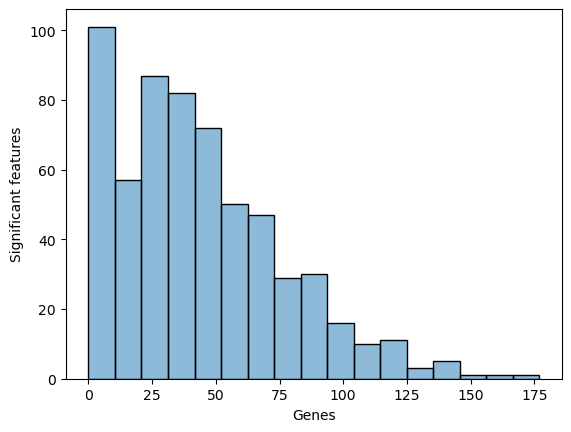

In [22]:
# Create hit lists for each file in file_list

for profile_file, cell_line, condition in file_list:
    print (f"Now loading {profile_file}")
    df = pd.read_csv(os.path.join(profile_file))
    df = df[df["Metadata_Foci_Barcode_MatchedTo_Barcode"].isin(guide_list)]
    
    print ("Converting feature strings to ints")
    df_int_feats,features_dic_reverse = features_to_ints(df)
    
    describe_expression(df, cell_line)

    df_genes = df_int_feats.query("Metadata_Foci_Barcode_MatchedTo_GeneCode != 'nontargeting'")
    genes = list(df_genes.Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    features_int = list(df_genes.columns)[2:]

    # Perform the statistics calculations for each feature
    print (f"Calculating statistics for {profile_file}")
    df_u_values , df_p_values = calculate_stats(features_int, genes, df_int_feats, p_value)

    # Return the ints to feature strings
    print (f'Converting ints to feature strings')
    df_p_values = df_p_values.rename(columns=features_dic_reverse)
    df_u_values = df_u_values.rename(columns=features_dic_reverse)
    df_p_values = df_p_values.reset_index(level=0).rename(columns={'index':'Gene'})
    df_u_values = df_u_values.reset_index(level=0).rename(columns={'index':'Gene'})
    if condition:
        df_p_values.to_csv(os.path.join(output_folder,f'{cell_line}_{condition}_significant_features_mann_whitney_p_values.csv.gz'),index=False)
        df_u_values.to_csv(os.path.join(output_folder,f'{cell_line}_{condition}_significant_features_mann_whitney_u_values.csv.gz'),index=False)
    else:
        df_p_values.to_csv(os.path.join(output_folder,f'{cell_line}_significant_features_mann_whitney_p_values_cp_features.csv.gz'),index=False)
        df_u_values.to_csv(os.path.join(output_folder,f'{cell_line}_significant_features_mann_whitney_u_values_cp_features.csv.gz'),index=False)

    # Plot distribution
    plt.clf()
    data = df_p_values.loc[df_p_values['Gene']=='sig_gene_count']
    data = pd.melt(data).drop([0])
    ax = sns.histplot(data,legend=False)
    ax.set_ylabel('Significant features')
    ax.set_xlabel('Genes')
    if condition:
        plt.savefig(os.path.join(output_folder,f'{cell_line}_{condition}_significant_features_histogram_cp_features.png'), dpi=1200)
    else:
        plt.savefig(os.path.join(output_folder,f'{cell_line}_significant_features_histogram_cp_features.png'), dpi=1200)
    plt.show()